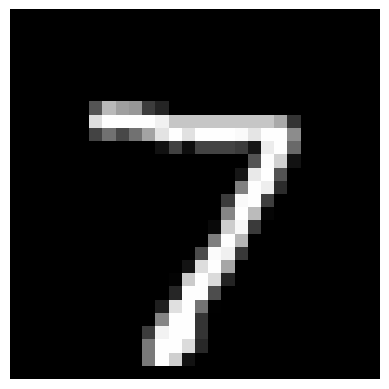

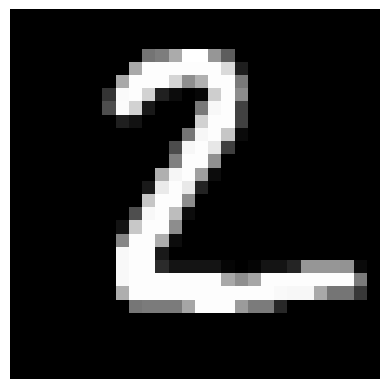

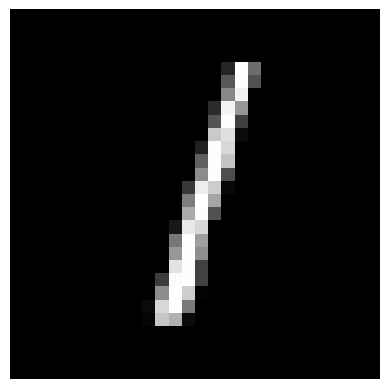

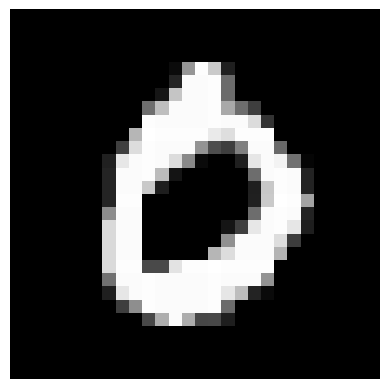

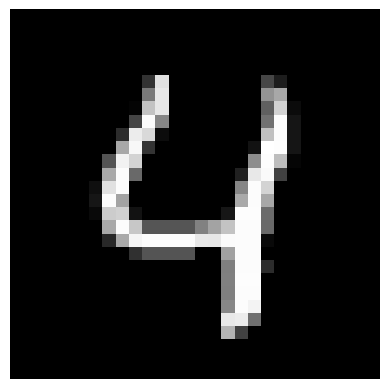

Epoch [1/10], Loss: 0.5297, Accuracy: 85.34%, Test Loss: 0.2833, Test Accuracy: 91.94%
Epoch [2/10], Loss: 0.3366, Accuracy: 90.31%, Test Loss: 0.2252, Test Accuracy: 93.46%
Epoch [3/10], Loss: 0.2964, Accuracy: 91.39%, Test Loss: 0.2094, Test Accuracy: 94.07%
Epoch [4/10], Loss: 0.2734, Accuracy: 92.02%, Test Loss: 0.1903, Test Accuracy: 94.28%
Epoch [5/10], Loss: 0.2608, Accuracy: 92.42%, Test Loss: 0.1832, Test Accuracy: 94.52%
Epoch [6/10], Loss: 0.2460, Accuracy: 92.83%, Test Loss: 0.1601, Test Accuracy: 95.39%
Epoch [7/10], Loss: 0.2380, Accuracy: 93.04%, Test Loss: 0.1533, Test Accuracy: 95.50%
Epoch [8/10], Loss: 0.2273, Accuracy: 93.43%, Test Loss: 0.1470, Test Accuracy: 95.88%
Epoch [9/10], Loss: 0.2224, Accuracy: 93.52%, Test Loss: 0.1399, Test Accuracy: 95.88%
Epoch [10/10], Loss: 0.2193, Accuracy: 93.57%, Test Loss: 0.1469, Test Accuracy: 95.67%


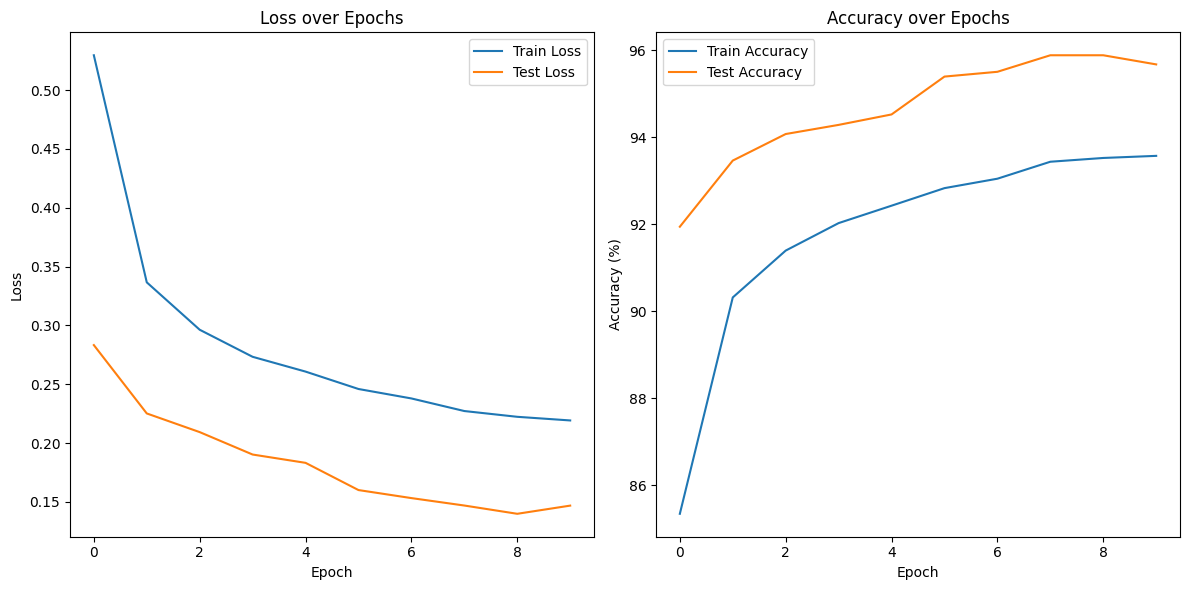

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.optim import SGD
import torch.nn as nn
from torchvision import datasets, transforms
import pandas as pd  # Thêm thư viện để lưu kết quả

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  
])

# Load datasets
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

def imshow(img):
    img = img / 2 + 0.5  
    plt.imshow(img.numpy().squeeze(), cmap='gray')
    plt.axis('off')  
    plt.show()

# Hiển thị 5 ảnh đầu tiên trong tập dữ liệu testing
count = 0
for images, labels in testloader:  # Duyệt qua các batch trong testloader
    for i in range(5):  # Lặp qua 5 ảnh đầu tiên trong batch
        imshow(images[i])  # Hiển thị ảnh
        count += 1
        if count >= 5:  # Khi đủ 5 ảnh thì dừng
            break
    if count >= 5:  # Thoát khỏi vòng lặp ngoài khi đã hiển thị đủ 5 ảnh
        break

def getModel(n_features):
    model = nn.Sequential(
        nn.Flatten(),
        nn.Linear(n_features, 128),
        nn.ReLU(),
        nn.BatchNorm1d(128),  
        nn.Dropout(0.5),      
        nn.Linear(128, 10)
    )
    return model.to(device)

n_features = 28 * 28
model = getModel(n_features)

lr = 0.01
optim = SGD(model.parameters(), lr=lr)
loss_fn = nn.CrossEntropyLoss()

def evaluate(model, testloader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():  
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_loss /= len(testloader)
    return test_loss, accuracy

n_epochs = 10
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        optim.zero_grad()
        loss.backward()
        optim.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * running_correct / total
    epoch_loss = running_loss / len(trainloader) 
    test_loss, test_accuracy = evaluate(model, testloader, loss_fn)
    print(f"Epoch [{epoch + 1}/{n_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

torch.save(model.state_dict(), 'mnist_model.pth')

metrics_df = pd.DataFrame({
    'Epoch': np.arange(1, n_epochs + 1),
    'Train Loss': train_losses,
    'Train Accuracy': train_accuracies,
    'Test Loss': test_losses,
    'Test Accuracy': test_accuracies
})
metrics_df.to_csv('training_metrics.csv', index=False)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.title('Loss over Epochs')
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.title('Accuracy over Epochs')
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()